In [135]:
import torch
import random
import numpy as np
import importlib

In [136]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Reusing cached mean and std
Mean: tensor([0.7635, 0.5461, 0.5705]), Std: tensor([0.1412, 0.1529, 0.1703])


Python(36486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Reusing cached mean and std


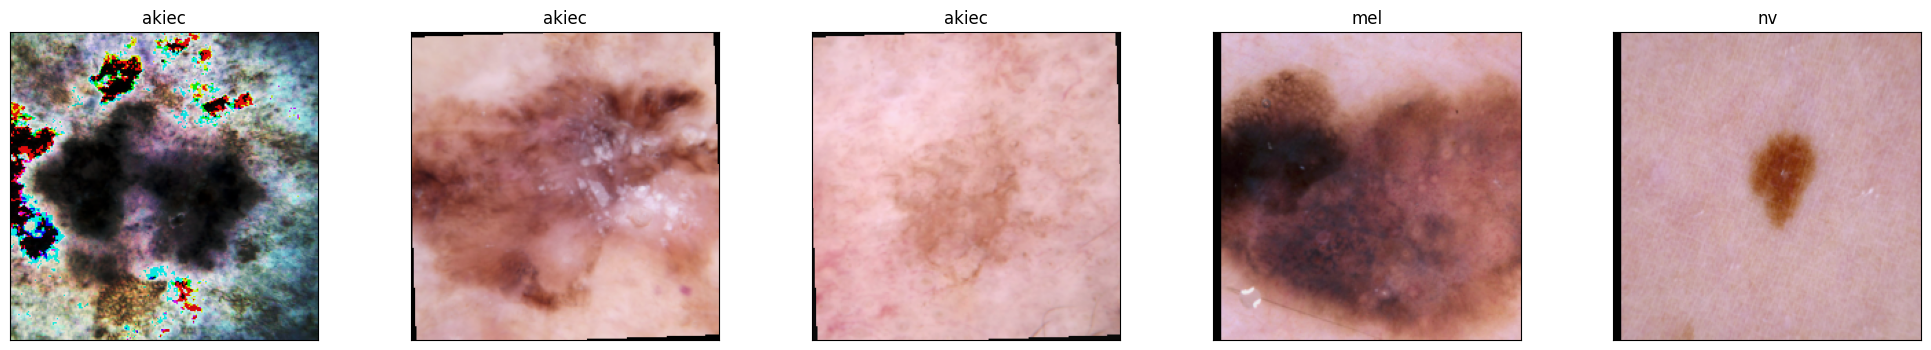

In [137]:
import data
importlib.reload(data)
data.visualize_one_batch(data.get_data_loaders())

In [138]:
import transfer
importlib.reload(transfer)

transfer.get_model_transfer_learning()

/Users/bence/Documents/Personal Projects/Skin/SkinVenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bence/Documents/Personal Projects/Skin/SkinVenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [139]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

In [140]:
import torch
import math

print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated\

True
True


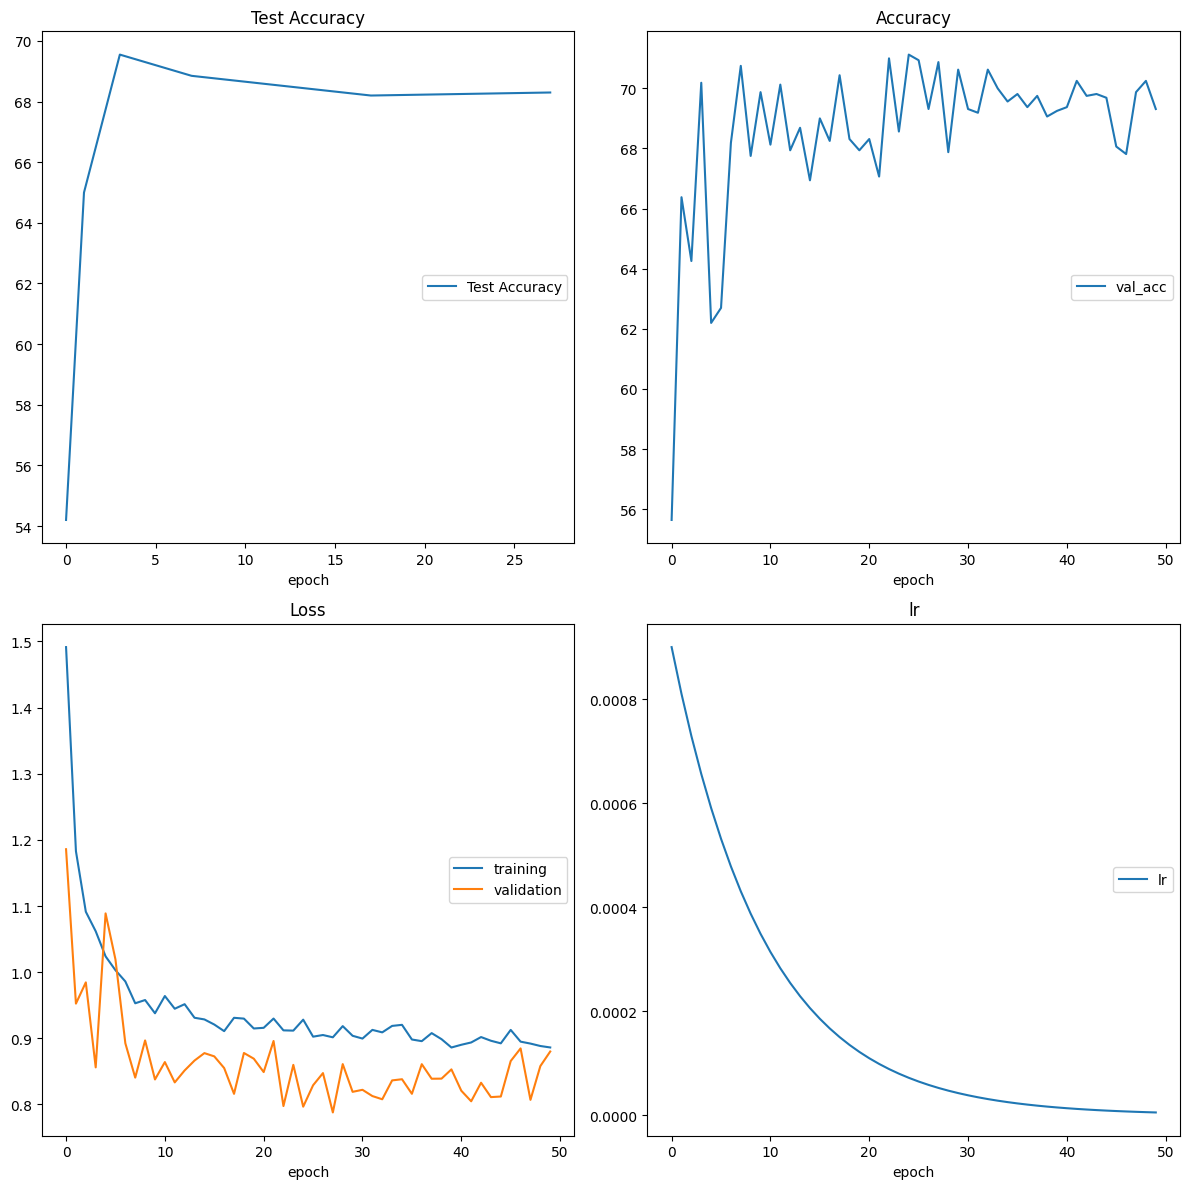

Epoch: 50 	Training Loss: 0.886193 	Validation Loss: 0.880093 	Validation Accuracy: 69.31%


In [142]:
import train
import optimization
importlib.reload(train)
importlib.reload(optimization)

model_transfer = transfer.get_model_transfer_learning(model_name="resnet18", n_classes=7)

# train the model
data_loaders = data.get_data_loaders(batch_size=batch_size)
optimizer = optimization.get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = optimization.get_loss()

train.optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer_ignore.pt",
    interactive_tracking=True
)

In [143]:
model_transfer = transfer.get_model_transfer_learning("resnet18", n_classes=7)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer_ignore.pt', map_location=torch.device('cpu')) )
data_loaders = data.get_data_loaders(batch_size=batch_size)
loss = optimization.get_loss()
train.one_epoch_test(data_loaders['test'], model_transfer, loss)

/Users/bence/Documents/Personal Projects/Skin/SkinVenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bence/Documents/Personal Projects/Skin/SkinVenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reusing cached mean and std
Mean: tensor([0.7635, 0.5461, 0.5705]), Std: tensor([0.1412, 0.1529, 0.1703])


Python(43138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Testing: 100%|██████████████████████████████████| 32/32 [00:15<00:00,  2.09it/s]

Test Loss: 0.841923


Test Accuracy: 68% (1366/2000)


(0.8419226035475731, tensor(68.3000))

In [144]:
def plot_confusion_matrix(pred, truth):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    gt = pd.Series(truth, name='Ground Truth')
    predicted = pd.Series(pred, name='Predicted')

    confusion_matrix = pd.crosstab(gt, predicted)

    fig, sub = plt.subplots(figsize=(14, 12))
    with sns.plotting_context("notebook"):
        idx = (confusion_matrix == 0)
        confusion_matrix[idx] = np.nan
        sns.heatmap(confusion_matrix, annot=True, ax=sub, linewidths=0.5, linecolor='lightgray', cbar=False)


In [145]:
'''

import predictor
importlib.reload(predictor)

# Get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

model_transfer = model_transfer.cpu()

model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer_ignore.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = data.compute_mean_std()
predictor_ = predictor.Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor_)
scripted_predictor.save("checkpoints/transfer_exported.pt")
'''

'\n\nimport predictor\nimportlib.reload(predictor)\n\n# Get the class names from our data loaders\nclass_names = data_loaders["train"].dataset.classes\n\nmodel_transfer = model_transfer.cpu()\n\nmodel_transfer.load_state_dict(\n    torch.load("checkpoints/model_transfer_ignore.pt", map_location="cpu")\n)\n\n# Let\'s wrap our model using the predictor class\nmean, std = data.compute_mean_std()\npredictor_ = predictor.Predictor(model_transfer, class_names, mean, std).cpu()\n\n# Export using torch.jit.script\nscripted_predictor = torch.jit.script(predictor_)\nscripted_predictor.save("checkpoints/transfer_exported.pt")\n'

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 2000/2000 [02:45<00:00, 12.11it/s]


Accuracy: 0.5235


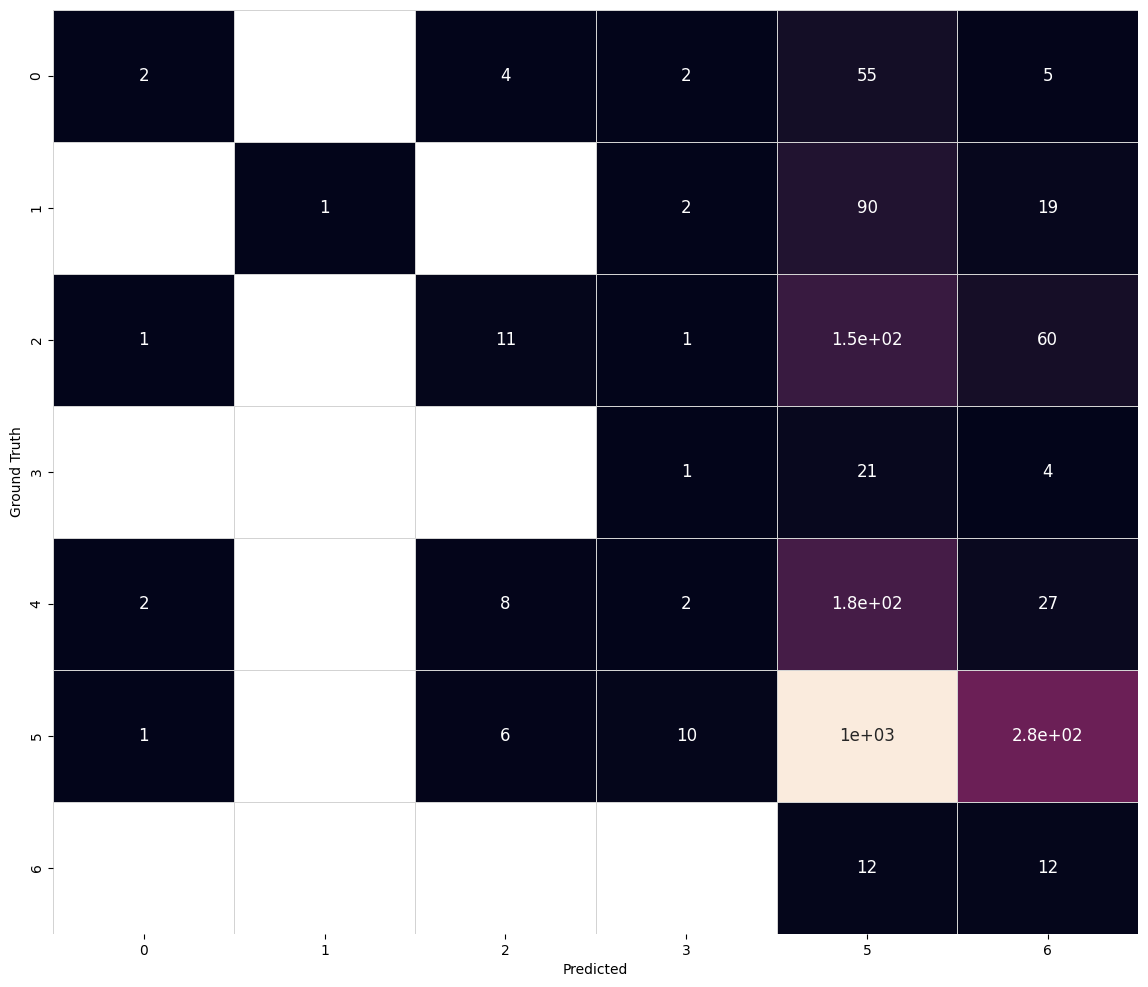

In [146]:
model_transfer = model_transfer.cpu()
pred, truth = predictor.predictor_test(data_loaders['test'], model_transfer)

plot_confusion_matrix(pred, truth)